Num GPUs Available:  0


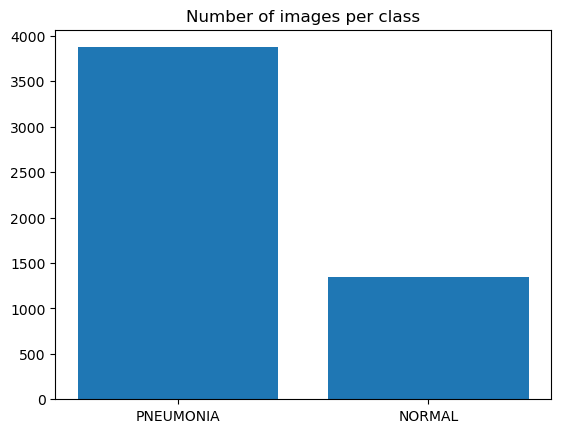

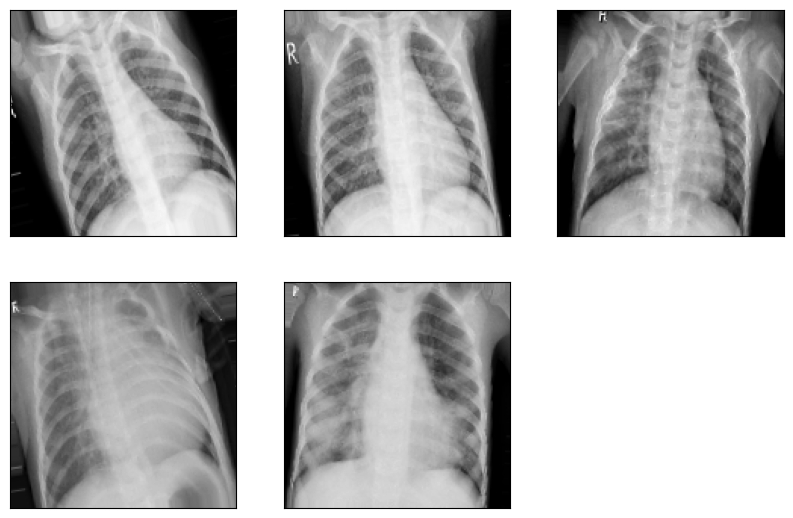

C:\Users\vikne\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20


C:\Users\vikne\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


163/163 ━━━━━━━━━━━━━━━━━━━━ 87s 479ms/step - accuracy: 0.7248 - loss: 0.8127 - learning_rate: 0.0010
Epoch 2/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 79s 476ms/step - accuracy: 0.8191 - loss: 0.3419 - learning_rate: 0.0010
Epoch 3/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 86s 523ms/step - accuracy: 0.9060 - loss: 0.2349 - learning_rate: 0.0010
Epoch 4/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 81s 491ms/step - accuracy: 0.8994 - loss: 0.2441 - learning_rate: 0.0010
Epoch 5/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 80s 480ms/step - accuracy: 0.9121 - loss: 0.2245 - learning_rate: 0.0010
Epoch 6/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 80s 483ms/step - accuracy: 0.9323 - loss: 0.1848 - learning_rate: 0.0010
Epoch 7/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 84s 510ms/step - accuracy: 0.9367 - loss: 0.1846 - learning_rate: 0.0010
Epoch 8/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 79s 475ms/step - accuracy: 0.9404 - loss: 0.1725 - learning_rate: 0.0010
Epoch 9/20
139/163 ━━━━━━━━━━━━━━━━━━━━ 11s 465ms/step - accuracy: 0.9402 - loss: 0.1702

In [ ]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Check GPU availability
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

# Define constants
img_size = 150
data_dir1 = '../../../chest_xray/train/PNEUMONIA'
data_dir2 = '../../../chest_xray/train/NORMAL'

# Function to load data
def load_data(data_dir1, data_dir2):
    data = []
    labels = ['PNEUMONIA', 'NORMAL']
    for dir in [data_dir1, data_dir2]:
        path = os.path.join(dir)
        if not os.path.exists(path):
            print(f"Directory {path} does not exist.")
            continue
        label = os.path.basename(dir)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                if img_arr is None:
                    print(f"Failed to read {img}. Skipping.")
                    continue
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data, dtype=object)

train_data = load_data(data_dir1, data_dir2)

# Visualize the number of images per class
labels_count = [0, 0]
for item in train_data:
    labels_count[item[1]] += 1

plt.bar(['PNEUMONIA', 'NORMAL'], labels_count)
plt.title('Number of images per class')
plt.show()

# Separate features and labels
def separate_features_labels(data):
    features, labels = [], []
    for feature, label in data:
        features.append(feature)
        labels.append(label)
    return np.array(features), np.array(labels)

x_train, y_train = separate_features_labels(train_data)

# Normalize the data
x_train = x_train / 255.0
x_train = x_train.reshape(-1, img_size, img_size, 1)

# Ensure data is not empty
if x_train.size == 0 or y_train.size == 0:
    print("Training data is empty. Please check the data loading process.")
else:
    # Data augmentation - rotation
    datagen = ImageDataGenerator(rotation_range=40)
    datagen.fit(x_train)

    # Display some augmented images
    def display_augmented_images(datagen, x_train, y_train):
        plt.figure(figsize=(10, 10))
        for x_batch, y_batch in datagen.flow(x_train, y_train, batch_size=5):
            for i in range(5):
                plt.subplot(330 + 1 + i)
                plt.xticks([])
                plt.yticks([])
                plt.imshow(x_batch[i].reshape(img_size, img_size), cmap='gray')
            plt.show()
            break

    display_augmented_images(datagen, x_train, y_train)

    # Define the model
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(img_size, img_size, 1)),
        MaxPooling2D((2, 2)),
        Dropout(0.2),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Dropout(0.2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Callbacks to adjust learning rate and stop training if stagnation occurs
    reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=2, min_lr=0.001)
    early_stop = EarlyStopping(monitor='loss', patience=3)

    # Train the model with augmented data
    history = model.fit(datagen.flow(x_train, y_train, batch_size=32), epochs=20, callbacks=[reduce_lr, early_stop])

    # Display performance curves
    def plot_learning_curves(history):
        plt.figure(figsize=(12, 6))

        # Plot loss
        plt.subplot(1, 2, 1)
        plt.plot(history.history['loss'], label='Training Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Training Loss')
        plt.legend()

        # Plot accuracy
        plt.subplot(1, 2, 2)
        plt.plot(history.history['accuracy'], label='Training Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.title('Training Accuracy')
        plt.legend()

        plt.tight_layout()
        plt.show()

    # Display learning curves
    plot_learning_curves(history)

    # Model evaluation
    scores = model.evaluate(x_train, y_train, verbose=0)
    print(f"Model accuracy: {scores[1]*100:.2f}%")
    print(f"Model loss: {scores[0]:.4f}")

    # Display some predictions
    def display_predictions(model, x_train, y_train):
        plt.figure(figsize=(10, 10))
        predictions = (model.predict(x_train) > 0.5).astype("int32")
        for i in range(9):
            plt.subplot(330 + 1 + i)
            plt.xticks([])
            plt.yticks([])
            plt.imshow(x_train[i].reshape(img_size, img_size), cmap='gray')
            plt.title(f"Pred: {predictions[i][0]}, True: {y_train[i]}")
        plt.show()

    display_predictions(model, x_train, y_train)

    print("Rotation augmentation and model evaluation complete.")